In [ ]:
!pip install pytorch-lightning


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 63.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-man

In [ ]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.3 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import lightning as L
import torchmetrics


class BaselineModel(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()

        self.estimator = nn.Sequential(
            nn.Linear(64 * 64, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        return self.estimator(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self.accuracy(y_hat, y)

        self.log("val_accuracy", self.accuracy)
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self.accuracy(y_hat, y)

        self.log("test_accuracy", self.accuracy)
        self.log("test_loss", loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
from torchvision import transforms
from torchvision.datasets import Imagenette
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint


# Prepare the dataset
train_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    transforms.Grayscale()
])

test_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    transforms.Grayscale()
])

train_dataset = Imagenette("data/imagenette/train/", split="train", size="160px", download=True, transform=train_transforms)

# Use 10% of the training set for validation
train_set_size = int(len(train_dataset) * 0.9)
val_set_size = len(train_dataset) - train_set_size

seed = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_set_size, val_set_size], generator=seed)
val_dataset.dataset.transform = test_transforms

# Use DataLoader to load the dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, num_workers=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, num_workers=8, shuffle=False)

# Configure the test dataset
test_dataset = Imagenette("data/imagenette/test/", split="val", size="160px", download=True, transform=test_transforms)

model = BaselineModel()

# Add EarlyStopping
early_stop_callback = EarlyStopping(monitor="val_loss",
                                    mode="min",
                                    patience=5)

# Configure Checkpoints
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min"
)

100%|██████████| 99003388/99003388 [00:08<00:00, 11447039.73it/s]


Extracting data/imagenette/train/imagenette2-160.tgz to data/imagenette/train/


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


100%|██████████| 99003388/99003388 [00:15<00:00, 6355859.52it/s]


Extracting data/imagenette/test/imagenette2-160.tgz to data/imagenette/test/


In [ ]:
# Fit the model
trainer = L.Trainer(callbacks=[early_stop_callback, checkpoint_callback])
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params
-------------------------------------------------
0 | estimator | Sequential         | 4.8 M 
1 | accuracy  | MulticlassAccuracy |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Evaluate the model on the test set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, num_workers=8, shuffle=False)
trainer.test(model=model, dataloaders=test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.3350318372249603     │
│         test_loss         │    2.3513524532318115     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.3350318372249603, 'test_loss': 2.3513524532318115}]

# **Basic CNN**

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from torchmetrics import Accuracy
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

class Basic_CNN(pl.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1_layer1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2_layer2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3_layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool_layer = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1_layer1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2_layer2 = nn.Linear(512, num_classes)

        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = self.pool_layer(F.relu(self.conv1_layer1(x)))
        x = self.pool_layer(F.relu(self.conv2_layer2(x)))
        x = self.pool_layer(F.relu(self.conv3_layer3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1_layer1(x))
        x = self.fc2_layer2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("val_loss", loss)
        self.log("val_accuracy", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_accuracy", acc, prog_bar=True)
        return loss

# Defining transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Dataset preparation
train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)

# Splitting the dataset
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data_loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# Early_stopping_callback and Checkpoint callback
early_stop_callback = EarlyStopping(monitor='val_loss', patience=3, mode='min')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min')

# Initializing Basic_CNN model
model = Basic_CNN()

# Initializing the Trainer without the test_dataloaders argument
trainer = pl.Trainer(max_epochs=20, callbacks=[early_stop_callback, checkpoint_callback])

# Fit model
trainer.fit(model, train_loader, val_loader)

# Providing the test dataloaders to the Trainer separately
trainer.test(dataloaders=test_loader)


100%|██████████| 170498071/170498071 [00:13<00:00, 13085797.60it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params
---------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_1/checkpoints/epoch=8-step=3168.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_1/checkpoints/epoch=8-step=3168.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7253999710083008     │
│         test_loss         │    0.8257654309272766     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8257654309272766, 'test_accuracy': 0.7253999710083008}]

# **All Convolutional Net**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torchmetrics import Accuracy
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import torchvision.models as models

class Transfer_Learning_Model(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        # Initialize ResNet model with pre-trained weights
        self.resnet = models.resnet18(pretrained=True)
        # Lock all layers except the last fully connected layer
        for param in self.resnet.parameters():
            param.requires_grad = False
        num_ftrs = self.resnet.fc.in_features
        # Update the last fully connected layer to match the class count
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.resnet(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("val_loss", loss)
        self.log("val_accuracy", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_accuracy", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# Define data preprocessing steps
transform_N = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset from specified directories
train_dataset_N = ImageFolder(root='./data/imagenette/train/imagenette2-160/train', transform=transform_N)
val_dataset_N = ImageFolder(root='./data/imagenette/train/imagenette2-160/val', transform=transform_N)
test_dataset_N = ImageFolder(root='./data/imagenette/test/imagenette2-160/val', transform=transform_N)

# Determine the number of classes in the dataset
num_classes_N = len(train_dataset_N.classes)
print("Number of classes:", num_classes_N)

# Configure data loaders
train_loader_N = DataLoader(train_dataset_N, batch_size=64, shuffle=True, num_workers=4)
val_loader_N = DataLoader(val_dataset_N, batch_size=64, shuffle=False, num_workers=4)
test_loader_N = DataLoader(test_dataset_N, batch_size=64, shuffle=False, num_workers=4)

# Callback for stopping early if validation loss doesn't improve
early_stop_callback_N = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Callback for saving model checkpoints
checkpoint_callback_N = ModelCheckpoint(monitor='val_loss', mode='min')

# Set up the model instance
model_N = Transfer_Learning_Model(num_classes=num_classes_N)

# Set up the Trainer with GPU settings
trainer_N = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback_N, checkpoint_callback_N], accelerator="gpu")

# Train the model
trainer_N.fit(model_N, train_loader, val_loader)

# Test the model
trainer_N.test(model_N, dataloaders=test_loader)


Number of classes: 10


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 94.1MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.ut

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.4480000138282776     │
│         test_loss         │    1.5809581279754639     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.5809581279754639, 'test_accuracy': 0.4480000138282776}]

# **Regularization added to Basic CNN**

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from torchmetrics import Accuracy
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

class Basic_CNN(pl.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1_layer1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2_layer2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3_layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool_layer = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1_layer1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2_layer2 = nn.Linear(512, num_classes)

        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = self.pool_layer(F.relu(self.conv1_layer1(x)))
        x = self.pool_layer(F.relu(self.conv2_layer2(x)))
        x = self.pool_layer(F.relu(self.conv3_layer3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1_layer1(x))
        x = self.fc2_layer2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("val_loss", loss)
        self.log("val_accuracy", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_accuracy", acc, prog_bar=True)
        return loss

# Define data preprocessing and augmentation steps
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Apply random cropping with padding
    transforms.RandomHorizontalFlip(),    # Apply random horizontal flipping
    transforms.RandomRotation(10),        # Apply random rotation within [-10, 10] degrees
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR10 dataset
train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)

# Split data into training and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Set up data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# Early stopping for validation loss
early_stop_callback = EarlyStopping(monitor='val_loss', patience=3, mode='min')

# Callback to save model checkpoints
checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min')

# Initialize the model
model = Basic_CNN()

# Set up the Trainer without the test_dataloaders argument
trainer = pl.Trainer(max_epochs=20, callbacks=[early_stop_callback, checkpoint_callback])

# Begin training process
trainer.fit(model, train_loader, val_loader)

# Test the model with the test data loader provided separately
trainer.test(dataloaders=test_loader)


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | conv1    | Conv2d             | 448   
1 | conv2    | Conv2d             | 4.6 K 
2 | conv3    | Conv2d             | 18.5 K
3 | pool     | MaxPool2d          | 0     
4 | fc1      | Linear             | 524 K 
5 | fc2      | Linear             | 5.1 K 
6 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
553 K     Trainable params
0         Non-trainable params
553 K     Total params
2.214     Total estima

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_3/checkpoints/epoch=19-step=7040.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_3/checkpoints/epoch=19-step=7040.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7325999736785889     │
│         test_loss         │    0.7745066285133362     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7745066285133362, 'test_accuracy': 0.7325999736785889}]

# **Transfer Learning**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from torchmetrics import Accuracy
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import torchvision.models as models
import matplotlib.pyplot as plt

# Define a Model with Transfer Learning
class FineTunedModel_N(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        # Initialize a pre-trained ResNet18 model with weights from ImageNet
        self.resnet = models.resnet18(pretrained=True)
        # Update the final layer to output the number of classes specific to CIFAR10
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
        # Set up an accuracy metric to evaluate model performance
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.resnet(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y) # Calculate loss for training
        self.log("train_loss", loss) # Log training loss for monitoring
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y) # Compute validation loss
        acc = self.accuracy(y_hat, y) # Calculate accuracy
        self.log("val_loss", loss) # Log validation loss
        self.log("val_accuracy", acc, prog_bar=True) # Log accuracy with progress bar

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y) # Compute test loss
        acc = self.accuracy(y_hat, y) # Calculate accuracy on test set
        self.log("test_loss", loss) # Log test loss
        self.log("test_accuracy", acc, prog_bar=True) # Log accuracy with progress bar

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3) # Define Adam optimizer
        return optimizer

# Set up data transformation and normalization
transform_N = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to fit the model input
    transforms.ToTensor(), # Convert images to tensor format
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the pixel values
])

# Load the CIFAR10 dataset
train_dataset_N = CIFAR10(root='./data', train=True, transform=transform_N, download=True)
test_dataset_N = CIFAR10(root='./data', train=False, transform=transform_N, download=True)

# Split training data into training and validation sets
train_size_N = int(0.9 * len(train_dataset_N))
val_size_N = len(train_dataset_N) - train_size_N
train_dataset_N, val_dataset_N = random_split(train_dataset_N, [train_size_N, val_size_N])

# Create data loaders for batching and shuffling
train_loader_N = DataLoader(train_dataset_N, batch_size=64, shuffle=True, num_workers=2)
val_loader_N = DataLoader(val_dataset_N, batch_size=64, shuffle=False, num_workers=2)
test_loader_N = DataLoader(test_dataset_N, batch_size=64, shuffle=False, num_workers=2)

# Set up early stopping to halt training if no improvement
early_stop_callback_N = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Set up model checkpointing to save the best model based on validation loss
checkpoint_callback_N = ModelCheckpoint(monitor='val_loss', mode='min')

# Instantiate the model for training
fine_tuned_model_N = FineTunedModel_N(num_classes=10)

# Initialize the trainer for training the model
trainer_N = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback_N, checkpoint_callback_N], accelerator="gpu")

# Begin training the model with the specified data loaders
trainer_N.fit(fine_tuned_model_N, train_loader_N, val_loader_N)

# Test the model performance on the held-out test dataset
trainer_N.test(fine_tuned_model_N, dataloaders=test_loader_N)

# Access the logged metrics from the training process
train_logs = trainer_N.callback_metrics
print("Keys in train_logs:", train_logs.keys())

# Plot the losses for training and validation over the epochs
if "train_loss" in train_logs and "val_loss" in train_logs:
    train_losses = train_logs["train_loss"]
    val_losses = train_logs["val_loss"]
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Training Loss') # Plot the training loss curve
    plt.plot(epochs, val_losses, label='Validation Loss') # Plot the validation loss curve
    plt.title('Training and Validation Loss') # Title for the plot
    plt.xlabel('Epochs') # Label for the x-axis
    plt.ylabel('Loss') # Label for the y-axis
    plt.legend() # Show legend for the plot
    plt.show() # Display the loss curves
else:
    print("Training and/or validation losses not found in the logs.")

# Plot the validation accuracy over the epochs
if "val_accuracy" in train_logs:
    val_accuracies = train_logs["val_accuracy"]
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')  # Plot the accuracy curve
    plt.title('Validation Accuracy') # Title for the accuracy plot
    plt.xlabel('Epochs') # Label for the x-axis
    plt.ylabel('Accuracy') # Label for the y-axis
    plt.legend() # Show legend for the plot
    plt.show() # Display the accuracy plot
else:
    print("Validation accuracies not found in the logs.")

# Print out the final accuracy achieved on the test dataset
final_test_accuracy = train_logs["test_accuracy"]
print("Final Test Accuracy:", final_test_accuracy)


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | resnet   | ResNet             | 11.2 M
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9009000062942505     │
│         test_loss         │    0.3352566957473755     │
└───────────────────────────┴───────────────────────────┘

Keys in train_logs: dict_keys(['test_loss', 'test_accuracy'])
Training and/or validation losses not found in the logs.
Validation accuracies not found in the logs.
Final Test Accuracy: tensor(0.9009)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from torchmetrics import Accuracy
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import torchvision.models as models
import matplotlib.pyplot as plt

# Define a model class for transfer learning tailored for the CIFAR10 dataset
class FineTunedModel_CIFAR10(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        # Initialize ResNet model without pre-trained weights for customization
        self.resnet = models.resnet18(pretrained=False)  # Load ResNet with no prior training
        # Adjust the last layer to fit the number of output classes for CIFAR10
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
        # Set up the accuracy metric for model evaluation
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.resnet(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss) # Log the loss for the training phase
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y) # Calculate validation loss
        acc = self.accuracy(y_hat, y) # Compute accuracy
        self.log("val_loss", loss) # Log the validation loss
        self.log("val_accuracy", acc, prog_bar=True) # Log accuracy with progress tracking

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y) # Compute loss on test data
        acc = self.accuracy(y_hat, y) # Calculate test accuracy
        self.log("test_loss", loss) # Log test loss
        self.log("test_accuracy", acc, prog_bar=True) # Log test accuracy with progress tracking

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3) # Set Adam optimizer with learning rate
        return optimizer

# Data preprocessing and augmentation
transform_CIFAR10 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download the CIFAR10 dataset
train_dataset_CIFAR10 = CIFAR10(root='./data', train=True, transform=transform_CIFAR10, download=True)
test_dataset_CIFAR10 = CIFAR10(root='./data', train=False, transform=transform_CIFAR10, download=True)

# Split the training data into training and validation sets
train_size_CIFAR10 = int(0.9 * len(train_dataset_CIFAR10))
val_size_CIFAR10 = len(train_dataset_CIFAR10) - train_size_CIFAR10
train_dataset_CIFAR10, val_dataset_CIFAR10 = random_split(train_dataset_CIFAR10, [train_size_CIFAR10, val_size_CIFAR10])

# Create data loaders for batching and shuffling
train_loader_CIFAR10 = DataLoader(train_dataset_CIFAR10, batch_size=64, shuffle=True, num_workers=4)
val_loader_CIFAR10 = DataLoader(val_dataset_CIFAR10, batch_size=64, shuffle=False, num_workers=4)
test_loader_CIFAR10 = DataLoader(test_dataset_CIFAR10, batch_size=64, shuffle=False, num_workers=4)

# Set up early stopping to prevent overfitting during training
early_stop_callback_CIFAR10 = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Set up a callback to save the best model weights based on validation loss
checkpoint_callback_CIFAR10 = ModelCheckpoint(monitor='val_loss', mode='min', save_weights_only=True)

# Initialize the fine-tuned model instance
fine_tuned_model_CIFAR10 = FineTunedModel_CIFAR10(num_classes=10)

# Create a Trainer object for managing training and evaluation processes
trainer_CIFAR10 = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback_CIFAR10, checkpoint_callback_CIFAR10], accelerator="gpu")

# Train the model using the CIFAR10 dataset
trainer_CIFAR10.fit(fine_tuned_model_CIFAR10, train_loader_CIFAR10, val_loader_CIFAR10)

# Evaluate the model's performance on the test dataset
trainer_CIFAR10.test(fine_tuned_model_CIFAR10, dataloaders=test_loader_CIFAR10)

# Retrieve the logged metrics after training
train_logs = trainer_CIFAR10.callback_metrics
print("Keys in train_logs:", train_logs.keys())

# Plot the training and validation loss over epochs
if "train_loss" in train_logs and "val_loss" in train_logs:
    train_losses = train_logs["train_loss"]
    val_losses = train_logs["val_loss"]
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Training Loss') # Plot training loss curve
    plt.plot(epochs, val_losses, label='Validation Loss') # Plot validation loss curve
    plt.title('Training and Validation Loss') # Title for the loss plot
    plt.xlabel('Epochs') # Label for the x-axis
    plt.ylabel('Loss') # Label for the y-axis
    plt.legend() # Display legend
    plt.show() # Render the plot
else:
    print("Training and/or validation losses not found in the logs.")

# Display final test accuracy from the logs
final_test_accuracy = train_logs["test_accuracy"]
print("Final Test Accuracy:", final_test_accuracy)


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | resnet   | ResNet             | 11.2 M
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
11.2 M    Trainable params
0 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8219000101089478     │
│         test_loss         │    0.7630646228790283     │
└───────────────────────────┴───────────────────────────┘

Keys in train_logs: dict_keys(['test_loss', 'test_accuracy'])
Training and/or validation losses not found in the logs.
Final Test Accuracy: tensor(0.8219)


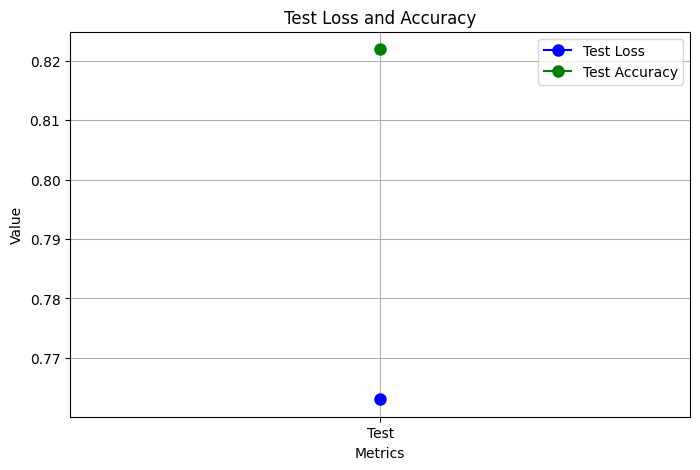

In [ ]:
import matplotlib.pyplot as plt

# Retrieve the test loss and accuracy values
test_loss = train_logs["test_loss"].clone().detach().item()
test_accuracy = train_logs["test_accuracy"].clone().detach().item()

# Create a plot for test loss and accuracy
plt.figure(figsize=(8, 5))
plt.plot(1, test_loss, marker='o', markersize=8, label='Test Loss', color='blue') # Plotting test loss
plt.plot(1, test_accuracy, marker='o', markersize=8, label='Test Accuracy', color='green') # Plotting test accuracy
plt.title('Test Loss and Accuracy') # Title for the plot
plt.xlabel('Metrics') # X-axis label indicating the type of metrics
plt.ylabel('Value') # Y-axis label indicating the metric values
plt.xticks([1], ['Test']) # Setting x-ticks to represent the test set
plt.legend() # Show the legend to identify the plots
plt.grid(True) # Enable grid for better readability
plt.show() # Display the generated plot


In [ ]:
test_loss = train_logs["test_loss"]
test_accuracy = train_logs["test_accuracy"]
epochs = range(1, len(test_loss) + 1)
plt.plot(epochs, test_loss, label='Test Loss')
plt.plot(epochs, val_losses, label='Test Accuracy')
plt.title('Test Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

TypeError: len() of a 0-d tensor